<ipython-input-143-1efd0cb7ae67>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() #make coordinate system


verlorene ML:  0
scheinbare ML:  0
gefundene ML:  25


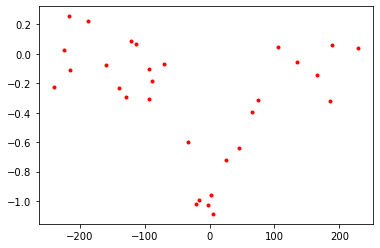

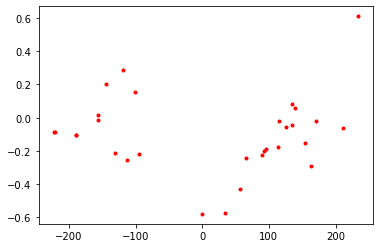

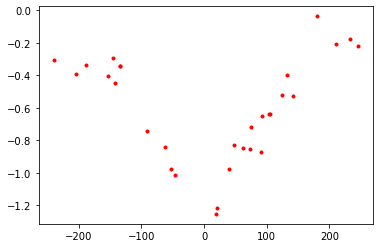

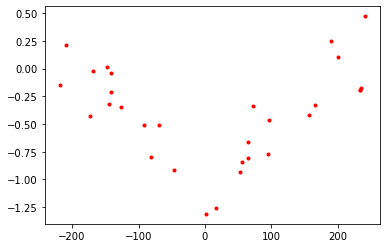

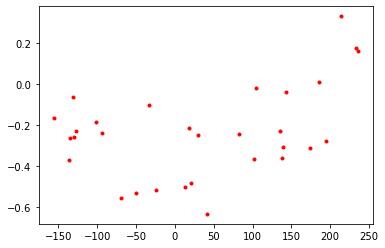

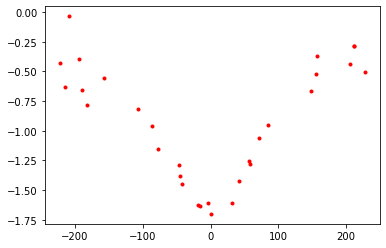

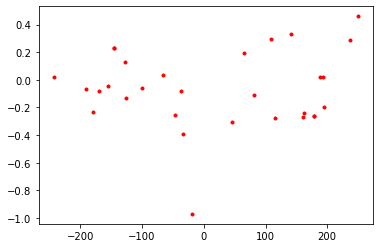

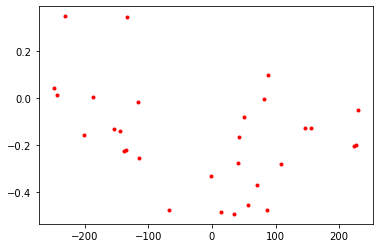

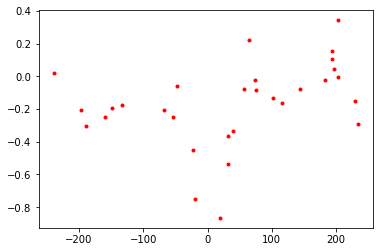

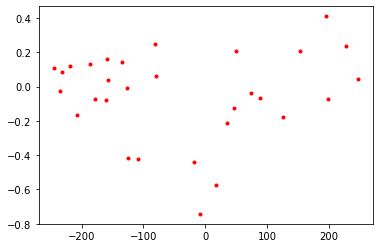

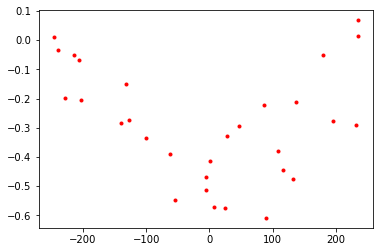

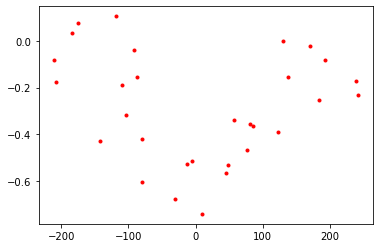

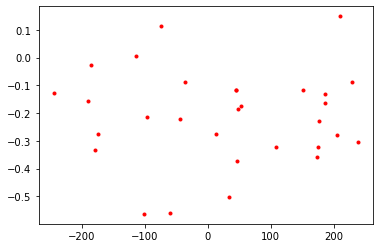

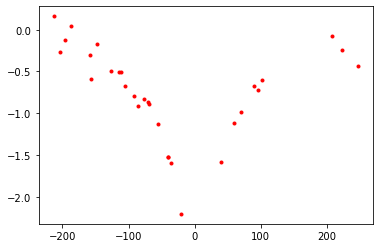

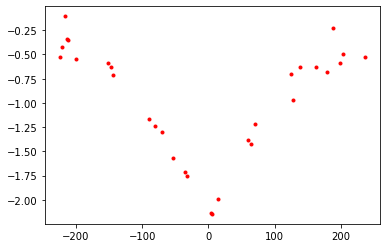

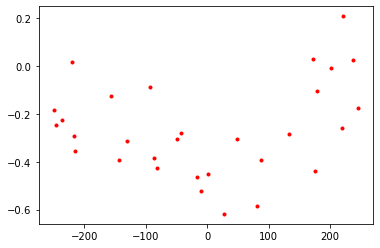

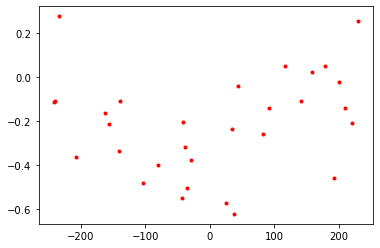

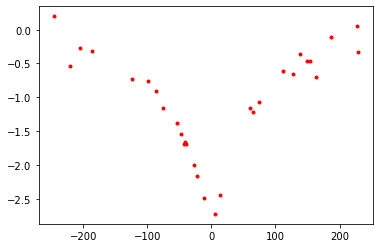

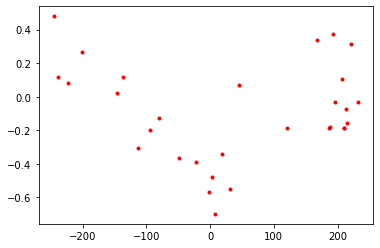

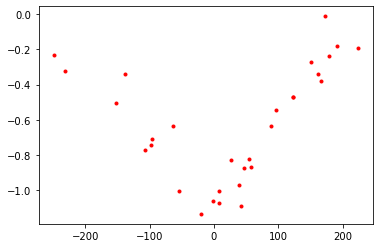

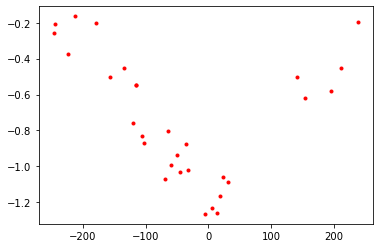

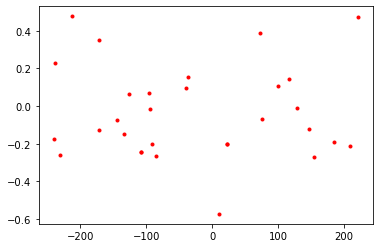

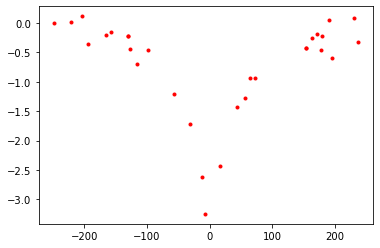

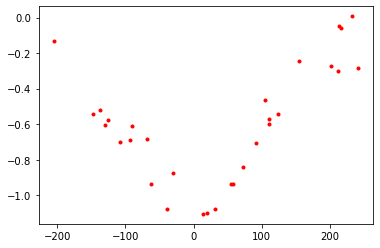

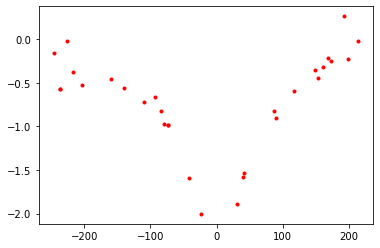

In [143]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import curve_fit as fit
import random

#other values
filternumber = 2
probability = 1
magpointamount = 30
t0=0 #Zeitpunkt max. Helligkeit
surveylength = 500 #wie lange gesamte Messung dauerte = maximale Eventdauer
standard_deviation = 0.2
mean_skew = -0.22994225279524635  #Mittelwert von 2 fields 
mean_std = 0.15856555  #Mittelwert von 2 fields 
mean_mean = 20.421268  #Mittelwert von 2 fields 
max_nm = 10000 #zwar viel höher als Mittelwert aller nms, aber hohe Standardabweichung ohne ML-Event lässt sich nur mit sehr überdurchschnittlich hohem nm erreichen
C = 0
LCamount = 50

#LISTS
detectlst = np.zeros(LCamount) #Liste gefilterter ML-Events, np.zeros(x) macht Liste mit x Nullen
truetruth_lst = np.zeros(LCamount) #Liste mit tatsächlichen ML-Events
lclist = [0 for i in range(LCamount)] #stellt synthetischen Datensatz dar -> pro LC Liste wie [Index (-> Object-ID), Magnitudenwerte, Zeitpunkte] -> muss Liste sein, da np.array keine arrays speichern kann aber kein Problem, da bei ZTF kein lclist erzeugt werden muss
filterlst = np.zeros(LCamount) #Index (wie object ID) wird in Liste eingefügt -> am Schluss gezählt, ob alle Kriterien erfüllt
skewlist = np.zeros(LCamount) #Skewness-Werte alles LC
stdlist = np.zeros(LCamount) #Standardabw-Werte alles LC
nmlist = np.zeros(LCamount)

def nm(array):
    nlst = np.zeros(len(array))
    std = np.std(array)
    for i in range(1, len(array)):
        nlst[i] = ((array[i] - array[i-1])**2)/((len(array)-1)*(std**2))
    n = np.sum(nlst)
    return n


for i in range(LCamount): #random Lichtkurven werden generiert
    #Produktion von künstlichen Lichtkurven
    l = random.randint(0, 5) #Helligkeit Stern
    p = random.randint(0, probability) #Wahrscheinlichkeit von 1/40

    if p == 1:
        truetruth_lst[i] = 1 #Nullen-Array an x-ter Stelle mit 1 ersetzt -> ML-Event
        # t0=0 #Zeitpunkt max. Helligkeit
        # umin=0.25
        # tE=25 #Zeitdauer, um Einstein-Radius zurückzulegen
        # standard_deviation = 0.2
        t = np.zeros(magpointamount) #(start, end, Anz. Striche zwischen start und end) -> x-Achse
        #freie Parameter hängen von t ab -> verändern sich mit der Zeit -> Körper bewegen sich
        a = np.zeros(magpointamount)
        umin = random.random()
        tE = random.randint(1, (1/2)*surveylength) #Zeitdauer, um Einstein-Radius zurückzulegen
        #random.uniform() gives random float between given range
        for x in range(magpointamount):
            t[x] = random.randint(-(1/2)*surveylength, (1/2)*surveylength)
        np.ndarray.sort(t)
        for d in t:  #Helligkeit A abhängig von u, u abhängig t
            u = np.sqrt(umin**2 + ((d-t0)/tE)**2)
            A = (u**2 + 2) / (u*np.sqrt(u**2 + 4)) + random.gauss(0, standard_deviation) #bei beiden Gauss-Rauschen machen
            M = -2.5*np.log10(A) - C
            a[np.where(t == d)] = M
        lclist[i] = np.array([i, a, t, umin, tE], dtype = object)
        #print("umin: ", umin, "tE: ", tE, "skew: ", skew(a), "std: ", np.std(a))
        #print("fit_umin: ", fit(th, t, a)[0][0], "fit_tE: ", fit(th, t, a)[0][1])
        plt.figure() #make coordinate system
        plt.plot(t, a,".", color = "red")#t,a = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!
        #plt.plot(t, th(t, fit(th, t, a)[0][0], fit(th, t, a)[0][1]))

    if p != 1: 
        
        t = np.zeros(magpointamount) #(start, end, Anz. Striche zwischen start und end) -> x-Achse
        #freie Parameter hängen von t ab -> verändern sich mit der Zeit -> Körper bewegen sich
        a = np.zeros(magpointamount)
        for x in range(magpointamount):
            t[x] = random.randint(-(1/2)*surveylength, (1/2)*surveylength)
        np.ndarray.sort(t)
        for d in t:
            A = mean_mean + random.gauss(0, standard_deviation)
            M = -2.5*np.log10(A) - C
            a[np.where(t == d)] = M
        lclist[i] = np.array([i, a, t], dtype=object)
        # plt.figure() #make coordinate system
        # plt.plot(t, a,".", color = "red")#t,a = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!

for i in range(LCamount):
    #skewlist[i] = skew(lclist[i][1])
    stdlist[i] = np.std(lclist[i][1])
    nmlist[i] = nm(lclist[i][1])

# for i in range(LCamount):
#     if skewlist[i] < mean_skew : #Minus weil sonst zu streng, lieber zu viel erkannt als eine nicht erkannt -> garantiert keine ML gehen verloren (wahrscheinlich doch unnötig nach Überprüfung, doch mal beibehalten)
#         filterlst[i] = 1 #bei jeweiligem Index von LC steht Anzahl bestandener Filter
for i in range(0, LCamount):
    if stdlist[i] > mean_std :
        detectlst[i] = 1
    else:
        detectlst[i] = 0

def filteredlc(): #damit man von anderen files darauf zugreifen kann
    return filteredlst

lost = 0
trap = 0
found = 0
uminlost = []
tElost = []
uminfound = []
tEfound = []
filteredlst = []

for i in range(0, LCamount):
    if ((truetruth_lst[i] == 1) and (detectlst[i] == 1)):
        found+=1
        uminfound.append(lclist[i][3])
        tEfound.append(lclist[i][4])
        filteredlst.append(lclist[i])
    if ((truetruth_lst[i] == 1) and (detectlst[i] == 0)):
        lost+=1
    if ((truetruth_lst[i] == 0) and (detectlst[i] == 1)):
        trap+=1
# plt.figure()
# #found = plt.plot(uminfound, tEfound, ".", color = "red")
# lost = plt.plot(uminlost, tElost, ".", color = "green")
# plt.legend((lost),('lost'),fontsize=8)
# plt.xlabel("umin")
# plt.ylabel("tE")
# plt.show()
#print("TEST (-> Fehlversuch falls 0): ", np.count_nonzero(truthlst == 1))#?????
if np.count_nonzero(detectlst == 1) != 0: #wenn kein sog "Fehlversuch"
    print("verlorene ML: ", lost)
    print("scheinbare ML: ", trap)
    print("gefundene ML: ", found)
    # print(truetruth_lst)
    # print(detectlst)
else:
    print("Noch nicht verstandener scheinbarer Fehlversuch. Nochmal ausführen bis es klappt.")